# Homework 3

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [1]:
# Import the Obspy modules that will be useful to download seismic data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [2]:
# answer below
# Download seismic data
network = 'XH'
station = 'DR01'
channel = 'LHN'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(year=2015, month=1, day=1)
Tend = UTCDateTime(year=2015, month=3, day=31)
fdsn_client = fdsn.Client('IRIS')
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, endtime=Tend, attach_response=True)
Z.merge(); Z.detrend(type='linear')


1 Trace(s) in Stream:
XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-03-31T00:00:00.000000Z | 1.0 Hz, 7689601 samples

In [3]:
# how many days did we download?
dt=Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

89


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [4]:
# answer below
from scipy.signal import butter,buttord,  sosfiltfilt, freqs

order = 4

# Lowpass
LowpassFilt_sos = butter(order, Wn = 1/100, btype='low', output='sos')
Z_LowpassFilt = sosfiltfilt(LowpassFilt_sos, Z[0].data)

# Bandpass
BandpassFilt_sos = butter(order, Wn = [1/100, 1/10], btype='band', output='sos')
Z_BandpassFilt = sosfiltfilt(BandpassFilt_sos, Z[0].data)

# Highpass
HighpassFilt_sos = butter(order, Wn = 1/10, btype='high', output='sos')
Z_HighpassFilt = sosfiltfilt(HighpassFilt_sos, Z[0].data)


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

Text(0, 0.5, 'Amplitude (m/s)')

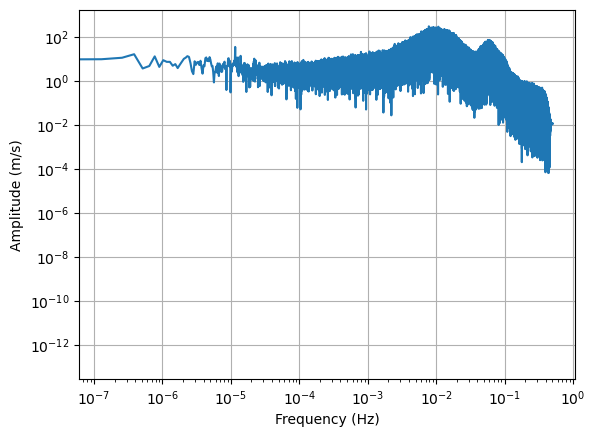

In [5]:
# import FFT modules
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
# answer below
## FFT the signals
# fill up until 2^N value to speed up the FFT as done in 2.6 feature engineering
Nfft = next_fast_len(int(Z[0].data.shape[0]))
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Zhat = fft(Z[0].data,n=Nfft)

plt.plot(freqVec, np.abs(Zhat[:Nfft//2])/Nfft)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (m/s)')


Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

### Two large peaks in spectral power occur near 0.01Hz and 0.1Hz. Comparing low and high frequency signals shows that low frequency variability has a much larger amplitude and contributes more significantly to the seismic data. The high frequency variability is much weaker than the low frequency varibility. Amplitudes near the peak frequencies in the band pass are nearly 2x the mean amplitude observed for the low frequency variability. 

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

In [7]:
# answer below
from numpy import random
from scipy.fftpack import ifft,ifftshift 

# Create noise vector as in 2.7 data transforms notebook
noise = random.randn(len(Z[0]))

# Make noise based on the spectrum of the noise data
npts = Z[0].stats.npts-1

## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0]-1)) 
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Nat = fft(noise,n=Nfft)

**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

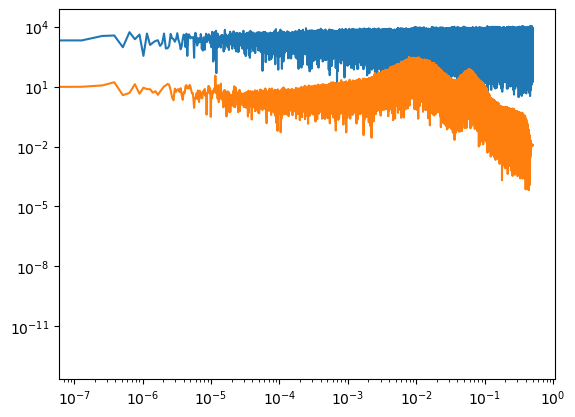

In [8]:
# answer below
plt.plot(freqVec,np.abs(Nat[:Nfft//2]))
plt.plot(freqVec, np.abs(Zhat[:Nfft//2])/Nfft)
plt.xscale('log');plt.yscale('log')

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

/tmp/ipykernel_565/1769263072.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3.5, shading='gouraud')


(0.01, 10)

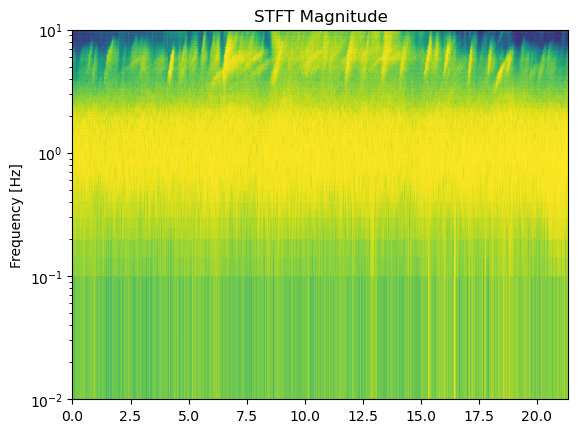

In [3]:
# answer below
from scipy.signal import stft

nperseg=1000
z=np.asarray(Z[0].data)
f, t, Zxx = stft(z, fs=100, nperseg=nperseg,noverlap=200)
plt.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3.5, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.yscale('log')
plt.ylim(10e-3,10)

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [19]:
# answer below
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ionosphere_df = pd.read_csv('/home/jovyan/MLGeo-Autumn22/homework/TEC/ioncorr_samo_015_2022_tonga.csv')
print(ionosphere_df.keys())

Index(['Unnamed: 0', 'GPS_seconds', 'satellite_number',
       'variometric_derived_TEC', 'variometric_derived_TEC_filtered',
       'absolute_derived_TEC', 'absolute_derived_TEC_filtered',
       'latitude_piercing_point', 'longitude_piercing_point',
       'satellite_azimuth', 'satellite_elevation_angle',
       'distance_to_piercing_point', 'time'],
      dtype='object')


Text(0.5, 1.0, 'First Two Hours of Data')

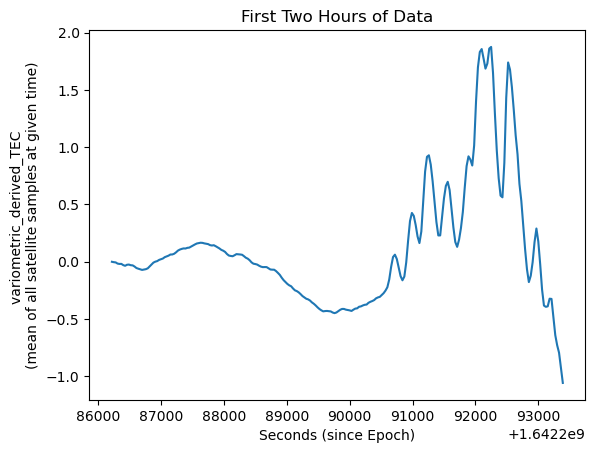

In [20]:
# data are spaced every 30 seconds
# 2 hours would be 2*60*2 = 240
variometric_derived_TEC_ts = []
for x in np.sort(ionosphere_df.time.unique()):
    x_data = ionosphere_df[ionosphere_df['time'] == x]
    mean_variometric_derived_TEC = x_data['variometric_derived_TEC'].mean()
    variometric_derived_TEC_ts.append(mean_variometric_derived_TEC)
plt.plot(ionosphere_df.time.unique()[:240], variometric_derived_TEC_ts[:240])
plt.xlabel('Seconds (since Epoch)')
plt.ylabel('variometric_derived_TEC \n(mean of all satellite samples at given time)')
plt.title('First Two Hours of Data')

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [21]:
# answer below
file_name = 'ioncorr_samo_015_2022_tonga.csv'
station_name = file_name.split('_')[1]
print('Station Name: ', station_name)

Station Name:  samo


## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

/tmp/ipykernel_285/1133085910.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(df_of_sat_data.datetimes, df_of_sat_data.variometric_derived_TEC_filtered,


Text(0, 0.5, 'Variometric Derived TEC (filtered)')

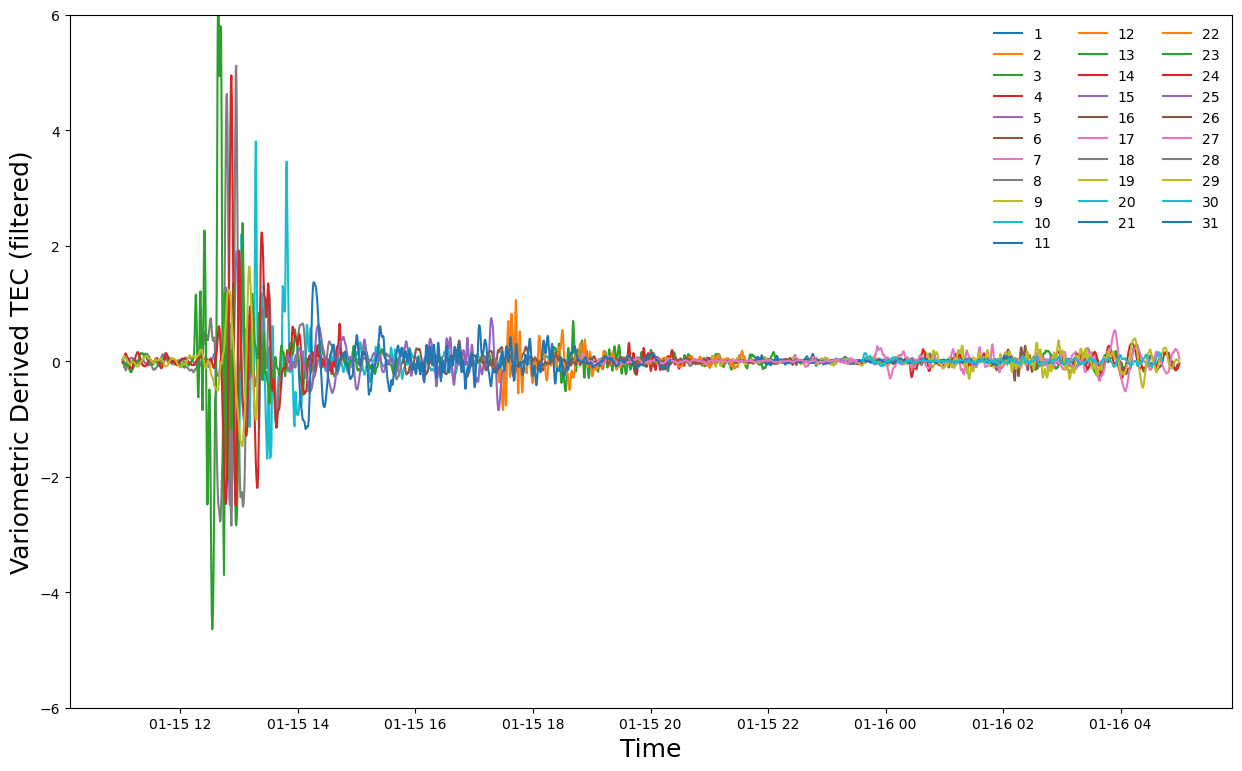

In [22]:
# Import the required package datetime
import datetime

# first, convert the timestamps to datetime objects but as a new series
ionosphere_df['datetimes'] = pd.to_datetime(ionosphere_df['time'], unit='s', utc=False)


# answer below
plt.figure(figsize=(15,9))
for sat_idx in range(1,32):
    df_of_sat_data = ionosphere_df[ionosphere_df['satellite_number'] == sat_idx]
    plt.plot_date(df_of_sat_data.datetimes, df_of_sat_data.variometric_derived_TEC_filtered, 
                  label=str(sat_idx), xdate=True, linestyle='solid', marker='None')
plt.ylim(-6,6)
plt.legend(ncol=3, loc=1, frameon=False)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Variometric Derived TEC (filtered)', fontsize=18)

    

You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. Select the time series of interest and plot the time series. What can you tell about the time-frequency characteristic of these disturbances?

/tmp/ipykernel_285/3836755501.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(sat_23_data.datetimes, sat_23_data.variometric_derived_TEC_filtered,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Data From Satellite 23')

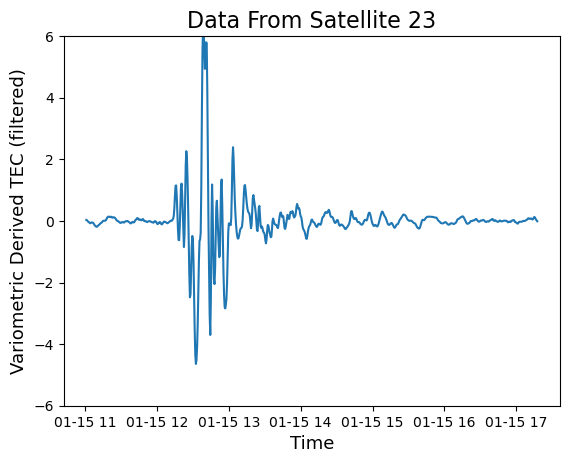

In [23]:
# answer below
sat_23_data = ionosphere_df[ionosphere_df['satellite_number'] == 23]
plt.plot_date(sat_23_data.datetimes, sat_23_data.variometric_derived_TEC_filtered, 
              xdate=True, linestyle='solid', marker='None')
plt.ylim(-6,6)
plt.legend(ncol=3, loc=1, frameon=False)
plt.xlabel('Time', fontsize=13)
plt.ylabel('Variometric Derived TEC (filtered)', fontsize=13)
plt.title('Data From Satellite 23', fontsize=16)

Calculate the sampling frequency by taking the time difference between two samples.

In [25]:
#answer below
sampleing_freq = sat_23_data.time.iloc[1] - sat_23_data.time.iloc[0]
print('Sampling Frequency: ', 1/sampleing_freq, 's^-1')


Sampling Frequency:  0.03333333333333333 s^-1


Perform the wavelet transform. You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

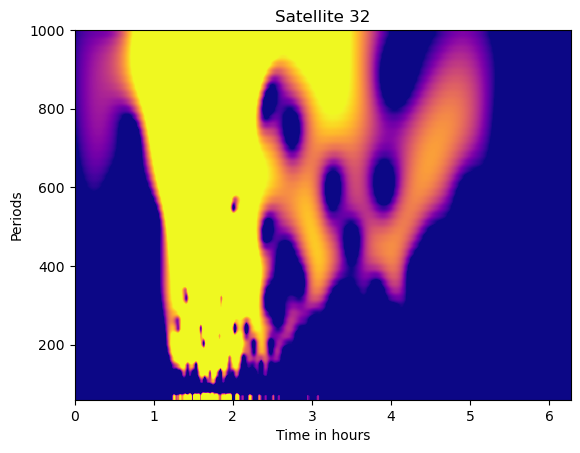

In [32]:
import scipy.signal as signal
# use the number of scales
w = range(1,50)

# frequency is that as found above
fs = 1/30

# relate scales with frequencies
freq = np.linspace(0.001, fs/2, 100)

# found on the internet that the morlet2 function is more appropriate for this than morlet
cwtm = signal.cwt(sat_23_data.variometric_derived_TEC_filtered.to_numpy(), signal.morlet2, w)
t = sat_23_data.time.to_numpy()

# Plot frequency in y time in x
plt.imshow(np.log10(np.abs(cwtm)), extent=[0,(t.max()-t.min())/3600.,1./freq.max(),1./freq.min()],\
           cmap='plasma', aspect='auto',vmax=0, vmin=-0.5,origin='lower')
plt.xlabel('Time in hours')
plt.ylabel('Periods')
plt.title('Satellite 23')
plt.show()

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

 ### We find that the dominant peaks occur about 1-3 hours after the beginning of the timeseries. I believe this graph also shows that dominate wavelengths are those that are near wavelet sales ~50 which I think is higher frequency (i.e., shorter timeperiods) compared to the rest of the graph. A second packet of waves is also visible at later times but are constricted to longer periods.

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc``, ``NCM_SpatialGrid.nc``, and ``NCM_AuxData.nc``.

We first download the data from our Dropbox folder


In [63]:
!pip install wget
import wget
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"


  Using cached wget-3.2-py3-none-any.whl



In the following we will prepare our data. Read the DataSets using the python NetCDF4 library.

In [1]:
# ansert below
import numpy as np
import netCDF4 as nc

# load nc datasets 
AuxData = nc.Dataset('NCM_AuxData.nc')
GeoFrameGrid = nc.Dataset('NCM_GeologicFrameworkGrids.nc')
SpatialGrid = nc.Dataset('NCM_SpatialGrid.nc')

**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``, which are data sets from the NC files. Use the matplotlib function``contourf``, and the variables for lat long ``x`` and ``y`` . You can use the argument ``levels`` to the contourf funxtion to split the color map into discrete contour levels, and the transparency argument ``alpha`` to be less than 1.

In [2]:
# pull both water table and surface elevation data from nc files
WT = AuxData['Water Table Depth'][:]
SE = GeoFrameGrid['Surface Elevation'][:]
x = SpatialGrid['x'][:]
y = SpatialGrid['y'][:]


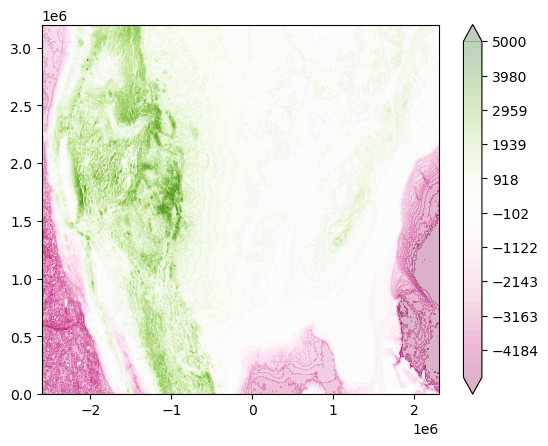

In [37]:
# Plot the Surface Elevation
plt.contourf(x, y, SE, alpha=0.3, cmap='PiYG', levels=np.linspace(-5000,5000), extend='both')
plt.title('Surface Elevation')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

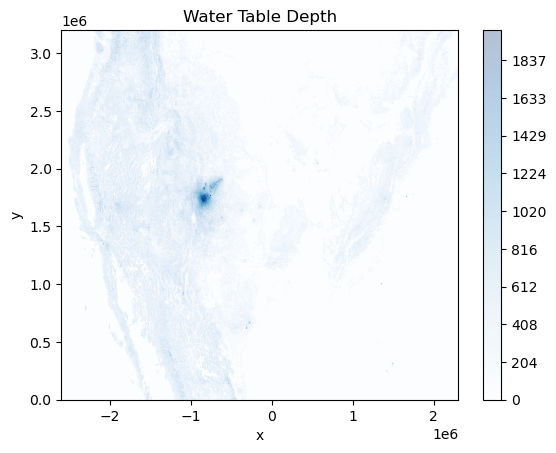

In [38]:
plt.contourf(x, y, WT, alpha=0.3, cmap='Blues', levels=np.linspace(0,2000))
plt.title('Water Table Depth')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

In [44]:
# recreate the lat long vectors.
minlat,maxlat = min(SpatialGrid['Latitude vector'][:]),max(SpatialGrid['Latitude vector'][:])
minlon,maxlon = min(SpatialGrid['Longitude vector'][:]),max(SpatialGrid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)

**b. Perform and plot the 2D Fourier transforms (4 points)**

this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


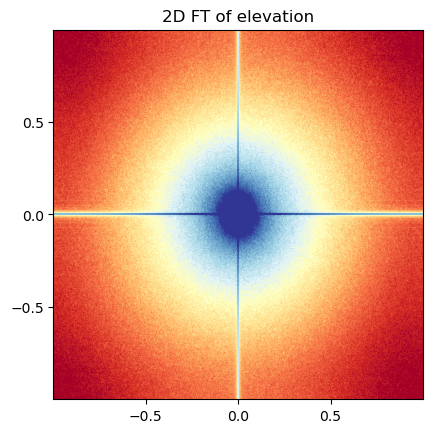

In [45]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift
import matplotlib.cm as cm

Zel = fft2(SE)


############################Taken from class notes############################
# make a vector of distances. Curvature is again ingnored as done in class
# make the wavenumber frequency vector: 
Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))


Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

# amplitude of the DEM
plt.imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
plt.title('2D FT of elevation')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.xticks([-0.5,0,0.5])
plt.yticks([-0.5,0,0.5])
plt.show()
############################Taken from class notes############################

this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


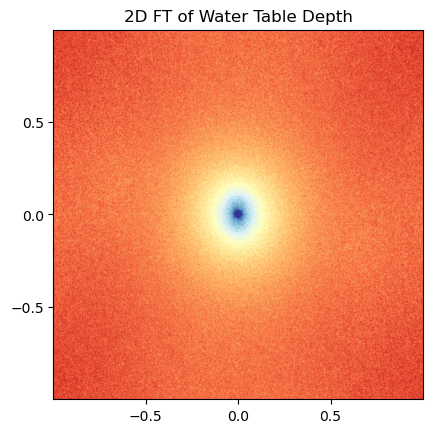

In [51]:
# answer below
from scipy.fftpack import fft2, fftfreq, fftshift, ifft2
import matplotlib.cm as cm

Zwt = fft2(WT)
# amplitude of the DEM
plt.imshow(fftshift(np.log10(np.abs(Zwt)/Zwt.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
plt.title('2D FT of Water Table Depth')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.xticks([-0.5,0,0.5])
plt.yticks([-0.5,0,0.5])
plt.show()

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

### The DEM data appears to have strong edge effects in all directions as a result of the discontinuities near the boarders of the elevation plots. Compared to the water table depth data, the DEM data has much higher frequency variability. This makes sense because the water table data is mostly below about 800 with only one concentration of much larger depths. This intense feature makes it so that the only frequencies of importance are very low frequencies.

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

In [9]:
# solution
#I tried to implement a 2d butterworth filter, but believe that a similar goal can be achieved 
# by just averaging the data in small chunks like the convolution suggestion
import scipy
from scipy.ndimage import uniform_filter # this just takes average over 4 adjacent pixels in all directions, the 'reflect' mirrors data near edges
import matplotlib.pyplot as plt

# this smoothing will reduce high frequency variability with lengths less than 8 km
WT_smoothed = scipy.ndimage.uniform_filter(WT, size=4, mode='reflect')
print(np.shape(WT_smoothed))

(4901, 3201)


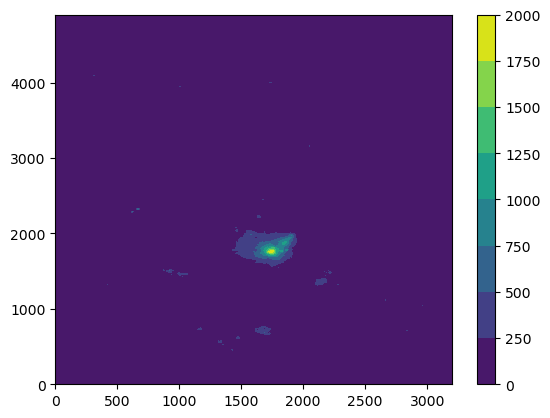

In [10]:
plt.contourf(WT_smoothed)
plt.colorbar()

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [11]:
from scipy.fftpack import fft2, fftfreq, fftshift, ifft2
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Sort the Fourier coefficients
Zwt = fft2(WT_smoothed)
Zsort = np.sort(np.abs(np.abs(Zwt).reshape(-1)))


Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

We are keeping up to 0.100000 the number of Fourier coefficients


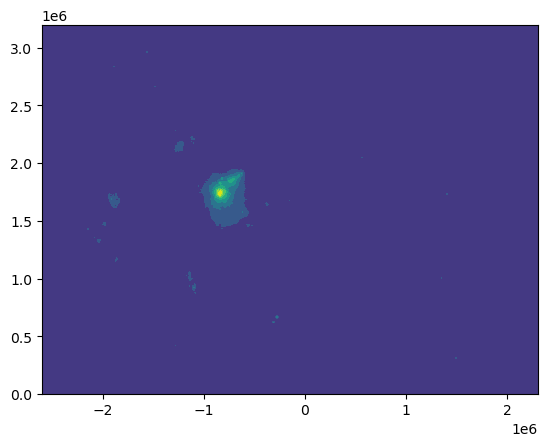

In [12]:
#answer below
from IPython import display
import time
for keep in (0.01,0.1):
    display.clear_output(wait=True)
    thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
    ind = np.abs(Zwt)>thresh
    Atlow = Zwt * ind # here we zero out the matrix
    # Here we count the number of non-zeros in the matrix
    print("We are keeping up to %f the number of Fourier coefficients" % keep)
    Alow = ifft2(Atlow).real
    plt.contourf(x, y, Alow)
    time.sleep(1)


Now we will compare the original 2D data set with the Fourier compressed data


We are keeping up to 0.100000 the number of Fourier coefficients


(-2600000.0, 2300000.0, 0.0, 3200000.0)

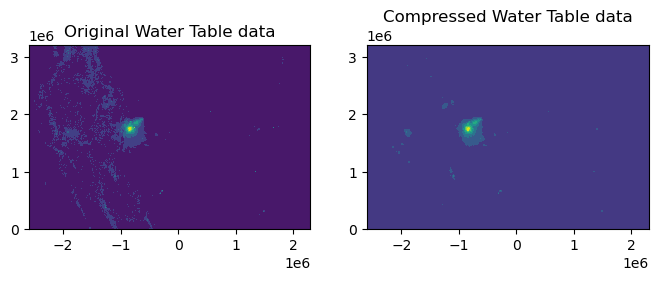

In [13]:
# answer below
keep=0.1
thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
ind = np.abs(Zwt)>thresh
Atlow = Zwt * ind # here we zero out the matrix
# Here we count the number of non-zeros in the matrix
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real


fig,ax=plt.subplots(1,2,figsize=(8,8),sharex=True)
ax[0].contourf(x, y, WT);ax[0].set_title('Original Water Table data')
ax[0].axis('scaled')
ax[1].contourf(x, y, Alow);ax[1].set_title('Compressed Water Table data')
ax[1].axis('scaled')